In [1]:
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [2]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [3]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [4]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [5]:
def unique_stat(df: pd.DataFrame) -> pd.Series:
    uniq_stat = df.nunique()
    return uniq_stat[(uniq_stat == 1) | (uniq_stat == len(df))]


def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

In [6]:
employee_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/employee.csv")
print(employee_df.shape)
employee_df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [7]:
unique_stat(employee_df)

Series([], dtype: int64)

In [8]:
na_stat(employee_df)

Series([], dtype: int64)

In [9]:
duplicates_stat(employee_df)

satisfaction_level  last_evaluation  number_project  average_montly_hours  time_spend_company  Work_accident  promotion_last_5years  department  salary  left
0.46                0.57             2               139                   3                   0              0                      sales       low     1       5
0.37                0.51             2               127                   3                   0              0                      sales       medium  1       3
0.42                0.53             2               142                   3                   0              0                      sales       low     1       3
0.41                0.46             2               128                   3                   0              0                      accounting  low     1       3
0.10                0.85             6               266                   4                   0              0                      sales       low     1       3
                           

In [10]:
employee_df = employee_df.drop_duplicates()
duplicates_stat(employee_df)

Series([], dtype: int64)

In [11]:
count_categories(employee_df)

department    10
salary         3
dtype: int64

In [12]:
print(employee_df.shape)
employee_df.head()

(11991, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


0    10000
1     1991
Name: left, dtype: int64


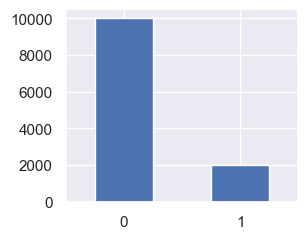

In [13]:
vc = employee_df["left"].value_counts()
print(vc)
employee_df["left"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [14]:
class EmployeeDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, feature_encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "left"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [15]:
train_df, test_df = train_test_split(employee_df, test_size=0.2, random_state=0)

train_dataset = EmployeeDataset(train_df)
test_dataset = EmployeeDataset(
    test_df,
    feature_encoder=train_dataset.feature_encoder,
    scaler=train_dataset.scaler,
)
len(train_dataset), len(test_dataset), train_dataset.num_features, train_dataset.classes

(9592, 2399, 9, ['0', '1'])

## Построение и обучение модели

In [16]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [17]:
class EmployeeClassifier(nn.Module):  # ~=98% (30 epochs, 0.001 lr)

    def __init__(self, num_features: int, num_classes: int):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)


class EmployeeCNNClassifier(nn.Module):  # ~=98% (50 epochs, 0.002 lr)
    LAST_CONV_OUT_CHANNELS = 64
    ADAPTIVE_AVG_POOL = 16

    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.LAST_CONV_OUT_CHANNELS, kernel_size=2),
            nn.BatchNorm1d(num_features=self.LAST_CONV_OUT_CHANNELS),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool1d(kernel_size=2),
        )
        self.avgpool = nn.AdaptiveAvgPool1d(self.ADAPTIVE_AVG_POOL)
        self.classifier = nn.Sequential(
            nn.Linear(self.LAST_CONV_OUT_CHANNELS * self.ADAPTIVE_AVG_POOL, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x.unsqueeze(1))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


class EmployeeRNNClassifier(nn.Module):  # ~=98% (77 epochs, 0.0025 lr)
    _STATE_T = t.Union[t.Optional[torch.Tensor], t.Optional[t.Tuple[torch.Tensor, torch.Tensor]]]
    rnn_state: _STATE_T

    def __init__(self, num_features: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=2,
            dropout=0.25,
            batch_first=True,
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes),
        )
        self.reset_rnn_state()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, rnn_state = self.rnn(x, self.rnn_state)
        self.keep_rnn_state(rnn_state)

        x = torch.flatten(x, 1)
        return self.classifier(x)

    def reset_rnn_state(self):
        self.rnn_state = None

    def keep_rnn_state(self, state: _STATE_T):
        if isinstance(self.rnn, nn.LSTM):
            self.rnn_state = (state[0].detach(), state[1].detach())
        else:
            self.rnn_state = state.detach()

    def train(self, mode: bool = True):
        self.reset_rnn_state()
        return super().train(mode)

In [18]:
torch.manual_seed(0)

# net = EmployeeClassifier(num_features=train_dataset.num_features, num_classes=len(train_dataset.classes)).to(DEVICE)
# net = EmployeeCNNClassifier(num_classes=len(train_dataset.classes)).to(DEVICE)
net = EmployeeRNNClassifier(
    num_features=train_dataset.num_features,
    hidden_size=64,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.0025)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

net

EmployeeRNNClassifier(
  (rnn): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.25)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [19]:
%%time

train_losses, train_accuracy, test_losses, test_accuracy = common_train(
    epochs=77,
    model=net,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=DEVICE,
)

Epoch 1
--------------------------------
Train Error: loss: 0.544609, accuracy: 0.7061
 Test Error: loss: 0.295863, accuracy: 0.8487

Epoch 2
--------------------------------
Train Error: loss: 0.283595, accuracy: 0.9046
 Test Error: loss: 0.274096, accuracy: 0.8808

Epoch 3
--------------------------------
Train Error: loss: 0.247088, accuracy: 0.9298
 Test Error: loss: 0.207075, accuracy: 0.9383

Epoch 4
--------------------------------
Train Error: loss: 0.243691, accuracy: 0.9389
 Test Error: loss: 0.215756, accuracy: 0.9391

Epoch 5
--------------------------------
Train Error: loss: 0.233316, accuracy: 0.9410
 Test Error: loss: 0.209641, accuracy: 0.9404

Epoch 6
--------------------------------
Train Error: loss: 0.226087, accuracy: 0.9413
 Test Error: loss: 0.202149, accuracy: 0.9496

Epoch 7
--------------------------------
Train Error: loss: 0.216302, accuracy: 0.9484
 Test Error: loss: 0.195528, accuracy: 0.9583

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

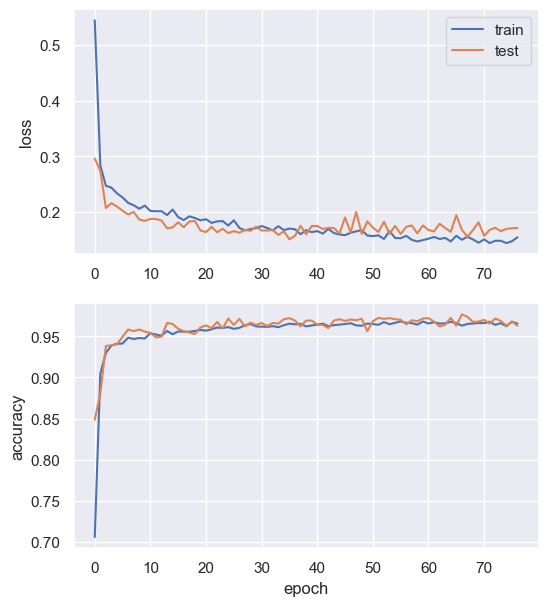

In [20]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)

In [21]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

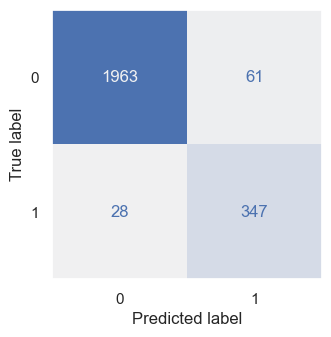

In [22]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [23]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2024
           1       0.85      0.93      0.89       375

    accuracy                           0.96      2399
   macro avg       0.92      0.95      0.93      2399
weighted avg       0.96      0.96      0.96      2399

